In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.wkt import loads
import geotable
import os

### Script Objectives:

This script filters our two main camera datasets (Amnesty Internation and Hikvision) via spatial joins on Brooklyn's shapefile. This will return a subset of the original camera datasets that we are interested in for our surviellance metric to be created for the neighborhoods across Brooklyn.

#### Input Files:

 **Cameras**

 * Amnesty International Camera Dataset: `os.path.dirname(os.path.dirname(path))+'/CapstoneData/amnesty_camera_counts_per_intersections.csv'`

 * Hikvision Camera Dataset: `../Data/NYC_Surveillance_Map_Hikvision.csv`


 **Shapefiles**

 * Brooklyn Census Blocks: `../Data/census blocks only Brooklyn.csv`

 * Brooklyn Census Tracts: `../Data/census tracts Brooklyn.csv`

 * Brooklyn Zip Codes: `../Data/zip code Brooklyn.csv`

#### Output Files:

 * Amnesty International Cameras in Brookyln: `../Data/amnesty_international_cameras_brooklyn.csv`

 * Hikvision Cameras in Brooklyn: `../Data/hikvision_camera_brooklyn.csv`
 
 * Aggregated Camera Counts for NYC Census Tracts: `../Data/NYC_tracts_camera_aggregates.csv`

In [2]:
#load camera data
path = os.getcwd()
parent = os.path.dirname(os.path.dirname(path))
amnesty = pd.read_csv(parent+'/CapstoneData/amnesty_camera_counts_per_intersections.csv')
hikvision = pd.read_csv('../Data/NYC_Surveillance_Map_Hikvision.csv', index_col = 0)

In [3]:
amnesty.head()

,PanoramaId,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median,type_dome_median,type_bullet_median,type_unknown_median,n_cameras_agreement,attached_street_agreement,...,attached_unknown_agreement,type_dome_agreement,type_bullet_agreement,type_unknown_agreement,Lat,Long,geometry_pano,BoroName,URL,ImageDate
0,--48RnFczF55WcDFpy5y_Q,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.870564,-73.869327,POINT (-73.86932652339482 40.87056425110688),Bronx,https://www.google.com/maps/@?api=1&map_action...,2019-08
1,--T2iuvfxXJrzbgD7R3W-g,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,2 vs 1,Unanimous,Unanimous,Unanimous,40.669099,-73.762447,POINT (-73.76244689609075 40.6690985670363),Queens,https://www.google.com/maps/@?api=1&map_action...,2020-10
2,--VGAsqPgTXxgZFXuhuhbg,0,0,0,0,0,0,0,Unanimous,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.766790,-73.771211,POINT (-73.7712107859631 40.76679030231237),Queens,https://www.google.com/maps/@?api=1&map_action...,2020-11
3,--YJY0GGvay_3W_O5ObeNQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.554253,-74.201603,POINT (-74.20160298846051 40.55425348634071),Staten Island,https://www.google.com/maps/@?api=1&map_action...,2019-09
4,--fUkaf5nn1-bm4KiJ9pVA,1,0,1,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,Unanimous,40.611084,-74.162803,POINT (-74.16280280196275 40.61108412672856),Staten Island,https://www.google.com/maps/@?api=1&map_action...,2019-09


In [4]:
hikvision.head()

,Name,Latitude,Longitude,Zip_Code,Borough,geometry_layer,wkt
0,100.12.128.86,40.630798,-74.098297,10301.0,Staten Island,Hikvision: Staten Island,POINT Z (-74.09829712 40.63079834 0)
1,100.12.139.126,40.604191,-74.107681,10301.0,Staten Island,Hikvision: Staten Island,POINT Z (-74.10768127 40.60419083 0)
2,100.12.139.79,40.605530,-74.102753,10301.0,Staten Island,Hikvision: Staten Island,POINT Z (-74.10275269 40.60552979 0)
3,100.12.141.104,40.627338,-74.103592,10301.0,Staten Island,Hikvision: Staten Island,POINT Z (-74.10359192 40.62733841 0)
4,100.12.152.177,40.624729,-74.094543,10301.0,Staten Island,Hikvision: Staten Island,POINT Z (-74.09454346 40.62472916 0)


In [11]:
#load shapefiles
nyc_blks = pd.read_csv('../Data/2020_Census_Blocks_-_Tabular.csv')
nyc_tracts = pd.read_csv('../Data/2020_Census_Tracts_-_Tabular.csv')
nyc_blkgp = gpd.read_file('../Data/tl_2017_36_bg/tl_2017_36_bg.shp')
nyc_nta = gpd.read_file('../Data/2010_NYC_Neighborhood_Tabulation_Areas/geo_export_11a21b79-3dcd-4a08-9471-c0f872559774.shp')
nyc_blks.head()

,the_geom,CB2020,BoroCode,BoroName,CT2020,BCTCB2020,GEOID,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-74.03995040788483 40.70089063...,1000,1,Manhattan,100,10001001000,360610001001000,6627.858318,1.204255e+06
1,MULTIPOLYGON (((-74.04387761639944 40.69018767...,1001,1,Manhattan,100,10001001001,360610001001001,4395.190183,6.401664e+05
2,MULTIPOLYGON (((-73.98511406569527 40.71378675...,1000,1,Manhattan,201,10002011000,360610002011000,1569.384823,1.292763e+05
3,MULTIPOLYGON (((-73.98505770255532 40.71307771...,1001,1,Manhattan,201,10002011001,360610002011001,1594.262855,1.393604e+05
4,MULTIPOLYGON (((-73.98495042073655 40.71235553...,2000,1,Manhattan,201,10002012000,360610002012000,2055.295961,2.633084e+05


In [51]:
nyc_tracts.head()

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-74.04387761639944 40.69018767...,1.00,1,Manhattan,100,1000100,NaN,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,11023.048501,1.844421e+06
1,MULTIPOLYGON (((-73.98449647076764 40.70950966...,2.01,1,Manhattan,201,1000201,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4754.495247,9.723121e+05
2,MULTIPOLYGON (((-73.99022012669926 40.71440493...,6.00,1,Manhattan,600,1000600,NaN,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,6976.286456,2.582705e+06
3,MULTIPOLYGON (((-73.9883662631772 40.716445702...,14.01,1,Manhattan,1401,1001401,NaN,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,5075.332000,1.006117e+06
4,MULTIPOLYGON (((-73.98507342254645 40.71908329...,14.02,1,Manhattan,1402,1001402,NaN,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4459.156019,1.226206e+06


In [52]:
nyc_blkgp.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,36,005,017500,2,360050175002,Block Group 2,G5030,S,23694,0,+40.8296335,-073.9152037,"POLYGON ((-73.91570 40.83054, -73.91485 40.830..."
1,36,005,014100,1,360050141001,Block Group 1,G5030,S,55934,0,+40.8245444,-073.9131209,"POLYGON ((-73.91661 40.82499, -73.91592 40.825..."
2,36,005,014500,1,360050145001,Block Group 1,G5030,S,47026,0,+40.8309816,-073.9050870,"POLYGON ((-73.90584 40.83106, -73.90505 40.832..."
3,36,005,007500,2,360050075002,Block Group 2,G5030,S,109058,0,+40.8202395,-073.9080678,"POLYGON ((-73.91035 40.81995, -73.91022 40.820..."
4,36,005,041800,1,360050418001,Block Group 1,G5030,S,140793,0,+40.8989195,-073.8564428,"POLYGON ((-73.86288 40.89515, -73.86146 40.897..."


In [12]:
nyc_nta.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry
0,4.0,Queens,081,QN08,St. Albans,7.741275e+07,45401.316803,"POLYGON ((-73.75205 40.70523, -73.75174 40.704..."
1,2.0,Bronx,005,BX28,Van Cortlandt Village,2.566612e+07,21945.719299,"POLYGON ((-73.88705 40.88435, -73.88705 40.884..."
2,4.0,Queens,081,QN55,South Ozone Park,8.246139e+07,36708.169305,"POLYGON ((-73.80577 40.68293, -73.80552 40.682..."
3,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.672066,"POLYGON ((-73.98017 40.66115, -73.98021 40.661..."
4,3.0,Brooklyn,047,BK50,Canarsie,8.208968e+07,43703.609666,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."


In [13]:
nyc_nta.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [14]:
nyc_nta = nyc_nta.to_crs(4326)
nyc_nta.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [53]:
nyc_blkgp.dtypes

STATEFP       object
COUNTYFP      object
TRACTCE       object
BLKGRPCE      object
GEOID         object
NAMELSAD      object
MTFCC         object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [5]:
# Convert the 'the_geom' column from WKT format to Shapely geometry objects
nyc_blks['the_geom'] = nyc_blks['the_geom'].apply(loads)
nyc_tracts['the_geom'] = nyc_tracts['the_geom'].apply(loads)

# Convert the pandas DataFrame to a GeoDataFrame
blks_gdf = gpd.GeoDataFrame(nyc_blks, geometry='the_geom', crs = '4326')
tracts_gdf = gpd.GeoDataFrame(nyc_tracts, geometry='the_geom', crs = '4326')

In [55]:
blks_gdf.head()

,the_geom,CB2020,BoroCode,BoroName,CT2020,BCTCB2020,GEOID,Shape_Leng,Shape_Area
0,"MULTIPOLYGON (((-74.03995 40.70089, -74.03945 ...",1000,1,Manhattan,100,10001001000,360610001001000,6627.858318,1.204255e+06
1,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",1001,1,Manhattan,100,10001001001,360610001001001,4395.190183,6.401664e+05
2,"MULTIPOLYGON (((-73.98511 40.71379, -73.98706 ...",1000,1,Manhattan,201,10002011000,360610002011000,1569.384823,1.292763e+05
3,"MULTIPOLYGON (((-73.98506 40.71308, -73.98544 ...",1001,1,Manhattan,201,10002011001,360610002011001,1594.262855,1.393604e+05
4,"MULTIPOLYGON (((-73.98495 40.71236, -73.98485 ...",2000,1,Manhattan,201,10002012000,360610002012000,2055.295961,2.633084e+05


In [56]:
print(len(blks_gdf), len(tracts_gdf),len(nyc_blkgp))

37589 2325 15463


In [15]:
bk_blks = blks_gdf[blks_gdf['BoroName'] == 'Brooklyn'].reset_index(drop = True)
bk_tracts = tracts_gdf[tracts_gdf['BoroName'] == 'Brooklyn'].reset_index(drop = True)
bk_bg = nyc_blkgp[nyc_blkgp['COUNTYFP'] == '047'].reset_index(drop = True)
bk_nta = nyc_nta[nyc_nta['boro_name'] == 'Brooklyn'].reset_index(drop = True)

In [16]:
print(len(bk_blks),len(bk_tracts), len(bk_bg), len(bk_nta))

9769 804 2085 51


<AxesSubplot:>

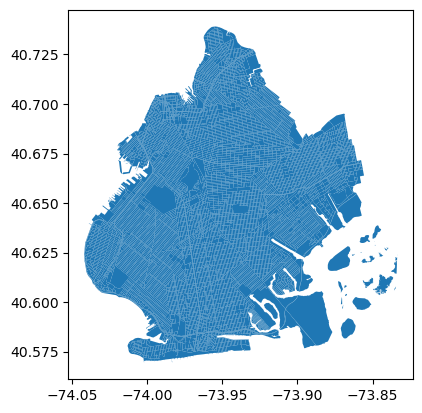

In [59]:
#plot
bk_blks.plot()

<AxesSubplot:>

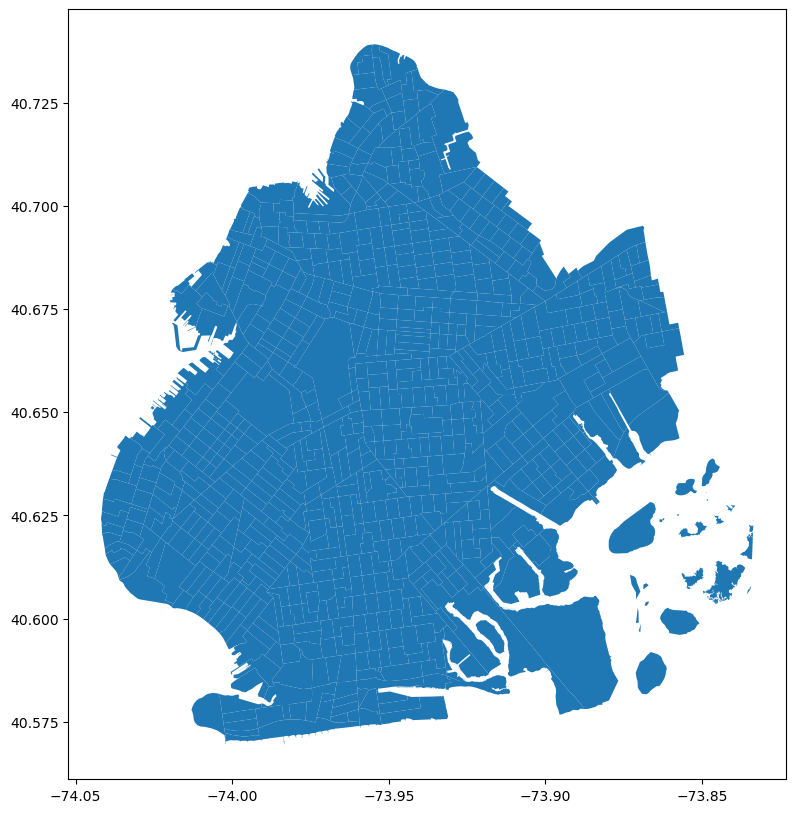

In [60]:
bk_tracts.plot(figsize = (10,10))

<AxesSubplot:>

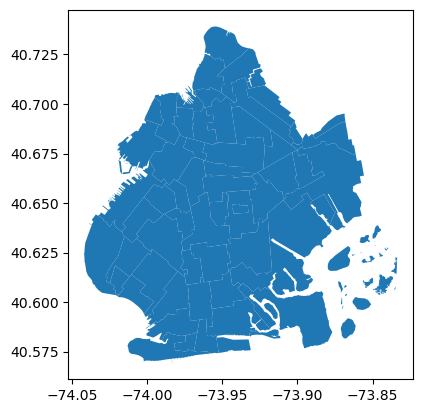

In [17]:
#plot
bk_nta.plot()

<AxesSubplot:>

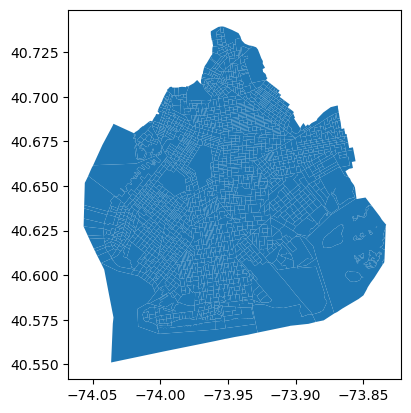

In [61]:
bk_bg.plot()

In [7]:
#get the boundary geometry
from shapely.ops import unary_union

boundary = unary_union(bk_tracts.geometry)
bndy_gdf = gpd.GeoDataFrame(geometry=[boundary], crs='EPSG:4326')

<AxesSubplot:>

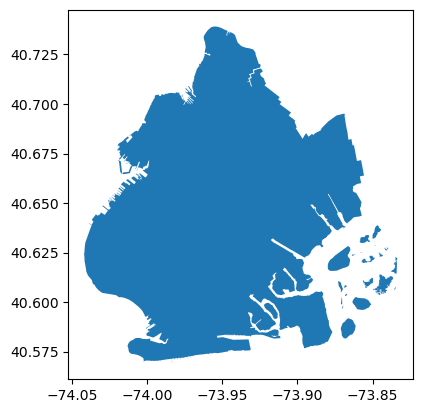

In [8]:
bndy_gdf.plot()

In [10]:
bndy_gdf.to_file('../Data/BrooklynBoundary.shp')

In [18]:
directories = ["../Data/BrooklynBlocks","../Data/BrooklynBlockGroups","../Data/BrooklynTracts","../Data/BrooklynNTAs"]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Directory created successfully")
    else:
        print("Directory already exists")

bk_blks.to_file('../Data/BrooklynBlocks/BrooklynBlocks.shp')
bk_tracts.to_file('../Data/BrooklynTracts/BrooklynTracts.shp')
bk_bg.to_file('../Data/BrooklynBlockGroups/BrooklynBlockGroups.shp')
bk_nta.to_file('../Data/BrooklynNTAs/BrooklynNTAs.shp')

Directory already exists
Directory already exists
Directory already exists
Directory created successfully


In [19]:
#covert the geometry points in the camera datasets and filter via spatial join
from shapely.geometry import Point

# Create a new column with Point geometries based on the 'lat' and 'lon' columns
geometry = [Point(xy) for xy in zip(amnesty['Long'], amnesty['Lat'])]

# Create a GeoDataFrame with the 'geometry' column and CRS set to EPSG:4326
amnesty_gdf = gpd.GeoDataFrame(amnesty, geometry=geometry, crs='EPSG:4326')
amnesty_gdf.head()

,PanoramaId,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median,type_dome_median,type_bullet_median,type_unknown_median,n_cameras_agreement,attached_street_agreement,...,type_dome_agreement,type_bullet_agreement,type_unknown_agreement,Lat,Long,geometry_pano,BoroName,URL,ImageDate,geometry
0,--48RnFczF55WcDFpy5y_Q,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.870564,-73.869327,POINT (-73.86932652339482 40.87056425110688),Bronx,https://www.google.com/maps/@?api=1&map_action...,2019-08,POINT (-73.86933 40.87056)
1,--T2iuvfxXJrzbgD7R3W-g,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.669099,-73.762447,POINT (-73.76244689609075 40.6690985670363),Queens,https://www.google.com/maps/@?api=1&map_action...,2020-10,POINT (-73.76245 40.66910)
2,--VGAsqPgTXxgZFXuhuhbg,0,0,0,0,0,0,0,Unanimous,Unanimous,...,Unanimous,Unanimous,Unanimous,40.766790,-73.771211,POINT (-73.7712107859631 40.76679030231237),Queens,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.77121 40.76679)
3,--YJY0GGvay_3W_O5ObeNQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.554253,-74.201603,POINT (-74.20160298846051 40.55425348634071),Staten Island,https://www.google.com/maps/@?api=1&map_action...,2019-09,POINT (-74.20160 40.55425)
4,--fUkaf5nn1-bm4KiJ9pVA,1,0,1,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.611084,-74.162803,POINT (-74.16280280196275 40.61108412672856),Staten Island,https://www.google.com/maps/@?api=1&map_action...,2019-09,POINT (-74.16280 40.61108)


In [20]:
#spatial join
# Conduct a spatial join between 'amnesty_gdf' and the boundary polygon
amnesty_bk = gpd.sjoin(amnesty_gdf, bndy_gdf, how='inner', predicate='within')
print(len(amnesty_gdf),len(amnesty_bk))

43406 10377


In [21]:
#repeat for the hikvision df
# hikvision['wkt'] = hikvision['wkt'].apply(loads)
# Create a new column with Point geometries based on the 'lat' and 'lon' columns
geometry = [Point(xy) for xy in zip(hikvision['Longitude'], hikvision['Latitude'])]


# Convert the pandas DataFrame to a GeoDataFrame
hikvision_gdf = gpd.GeoDataFrame(hikvision, geometry=geometry, crs = '4326')
hikvision_bk = gpd.sjoin(hikvision_gdf, bndy_gdf, how='inner', predicate='within')
print(len(hikvision_gdf),len(hikvision_bk))

16535 5996


In [22]:
amnesty_bk.head()

,PanoramaId,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median,type_dome_median,type_bullet_median,type_unknown_median,n_cameras_agreement,attached_street_agreement,...,type_bullet_agreement,type_unknown_agreement,Lat,Long,geometry_pano,BoroName,URL,ImageDate,geometry,index_right
6,--kQB7vdISN5ZhBDo82BHg,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,40.706633,-73.935702,POINT (-73.93570246701009 40.70663303266096),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.93570 40.70663),0
8,-0Kgxt4Lfda78gY2WuEMqA,0,0,0,0,0,0,0,2 vs 1,2 vs 1,...,Unanimous,2 vs 1,40.639826,-73.897770,POINT (-73.89777023441276 40.63982610941098),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.89777 40.63983),0
9,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.95673 40.69289),0
10,-0Y6fGJQcnKZ-crSKaVIfQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,40.662758,-73.885122,POINT (-73.88512163867377 40.66275783316144),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.88512 40.66276),0
14,-0yXEvW841dBjrs54VZKIA,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,40.655396,-74.003186,POINT (-74.00318577678686 40.65539642907692),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-06,POINT (-74.00319 40.65540),0


In [23]:
hikvision_bk.head()

,Name,Latitude,Longitude,Zip_Code,Borough,geometry_layer,wkt,geometry,index_right
10538,100.12.110.237,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460),0
10539,100.2.171.33,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460),0
10540,100.2.223.120,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460),0
10541,100.2.223.225,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460),0
10542,100.33.242.212,40.702461,-73.987801,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.9878006 40.70246124 0),POINT (-73.98780 40.70246),0


In [24]:
hikvision_bk = hikvision_bk.drop(columns = ['index_right']).reset_index(drop = True)
hikvision_bk.head()

,Name,Latitude,Longitude,Zip_Code,Borough,geometry_layer,wkt,geometry
0,100.12.110.237,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
1,100.2.171.33,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
2,100.2.223.120,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
3,100.2.223.225,40.694599,-73.990639,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99063873 40.69459915 0),POINT (-73.99064 40.69460)
4,100.33.242.212,40.702461,-73.987801,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.9878006 40.70246124 0),POINT (-73.98780 40.70246)


In [25]:
amnesty_bk = amnesty_bk.drop(columns = ['index_right']).reset_index(drop = True)
amnesty_bk.head()

,PanoramaId,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median,type_dome_median,type_bullet_median,type_unknown_median,n_cameras_agreement,attached_street_agreement,...,type_dome_agreement,type_bullet_agreement,type_unknown_agreement,Lat,Long,geometry_pano,BoroName,URL,ImageDate,geometry
0,--kQB7vdISN5ZhBDo82BHg,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.706633,-73.935702,POINT (-73.93570246701009 40.70663303266096),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.93570 40.70663)
1,-0Kgxt4Lfda78gY2WuEMqA,0,0,0,0,0,0,0,2 vs 1,2 vs 1,...,Unanimous,Unanimous,2 vs 1,40.639826,-73.897770,POINT (-73.89777023441276 40.63982610941098),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.89777 40.63983)
2,-0KlvkzMEDcLyTePpuY3sg,5,0,5,0,0,0,0,All disagree,Unanimous,...,Unanimous,Unanimous,Unanimous,40.692888,-73.956733,POINT (-73.95673315914595 40.69288765636261),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11,POINT (-73.95673 40.69289)
3,-0Y6fGJQcnKZ-crSKaVIfQ,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.662758,-73.885122,POINT (-73.88512163867377 40.66275783316144),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2018-06,POINT (-73.88512 40.66276)
4,-0yXEvW841dBjrs54VZKIA,0,0,0,0,0,0,0,2 vs 1,Unanimous,...,Unanimous,Unanimous,Unanimous,40.655396,-74.003186,POINT (-74.00318577678686 40.65539642907692),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-06,POINT (-74.00319 40.65540)


In [69]:
directories = ["../Data/amnesty","../Data/hikvision"]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Directory created successfully")
    else:
        print("Directory already exists")


amnesty_bk.to_file('../Data/amnesty/amnesty_international_cameras_brooklyn.shp')

Directory created successfully
Directory created successfully


/var/folders/9f/7xdrpjw15kn4wccwzb5xhr0m0000gn/T/ipykernel_25626/160956263.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  amnesty_bk.to_file('../Data/amnesty/amnesty_international_cameras_brooklyn.shp')


In [70]:
hikvision_bk.to_file('../Data/hikvision/hikvision_camera_brooklyn.shp')

/var/folders/9f/7xdrpjw15kn4wccwzb5xhr0m0000gn/T/ipykernel_25626/3402395460.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hikvision_bk.to_file('../Data/hikvision/hikvision_camera_brooklyn.shp')


### Spatial Aggregation to Census Tracts

In [28]:
tract_amnesty = gpd.sjoin(bk_tracts,amnesty_bk, how = 'left',predicate = 'contains')

In [29]:
tract_amnesty.head()

,the_geom,CTLabel,BoroCode,BoroName_left,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,...,attached_unknown_agreement,type_dome_agreement,type_bullet_agreement,type_unknown_agreement,Lat,Long,geometry_pano,BoroName_right,URL,ImageDate
0,"MULTIPOLYGON (((-73.99093 40.70077, -73.99087 ...",1.0,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,...,Unanimous,Unanimous,Unanimous,Unanimous,40.699418,-73.992067,POINT (-73.9920668496865 40.69941770896693),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-07
0,"MULTIPOLYGON (((-73.99093 40.70077, -73.99087 ...",1.0,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,...,Unanimous,2 vs 1,Unanimous,2 vs 1,40.699872,-73.991105,POINT (-73.99110522703761 40.69987157288121),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-05
0,"MULTIPOLYGON (((-73.99093 40.70077, -73.99087 ...",1.0,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,...,2 vs 1,Unanimous,Unanimous,Unanimous,40.700047,-73.991766,POINT (-73.99176627587403 40.70004689937525),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-05
0,"MULTIPOLYGON (((-73.99093 40.70077, -73.99087 ...",1.0,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,...,Unanimous,Unanimous,Unanimous,Unanimous,40.700172,-73.990956,POINT (-73.99095561944227 40.70017217721467),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2020-11
0,"MULTIPOLYGON (((-73.99093 40.70077, -73.99087 ...",1.0,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,...,Unanimous,2 vs 1,Unanimous,Unanimous,40.700766,-73.990985,POINT (-73.99098545669757 40.70076576946393),Brooklyn,https://www.google.com/maps/@?api=1&map_action...,2019-07


In [30]:
tract_amnesty.columns

Index(['the_geom', 'CTLabel', 'BoroCode', 'BoroName_left', 'CT2020',
       'BoroCT2020', 'CDEligibil', 'NTAName', 'NTA2020', 'CDTA2020',
       'CDTANAME', 'GEOID', 'Shape_Leng', 'Shape_Area', 'index_right',
       'PanoramaId', 'n_cameras_median', 'attached_street_median',
       'attached_building_median', 'attached_unknown_median',
       'type_dome_median', 'type_bullet_median', 'type_unknown_median',
       'n_cameras_agreement', 'attached_street_agreement',
       'attached_building_agreement', 'attached_unknown_agreement',
       'type_dome_agreement', 'type_bullet_agreement',
       'type_unknown_agreement', 'Lat', 'Long', 'geometry_pano',
       'BoroName_right', 'URL', 'ImageDate'],
      dtype='object')

In [31]:
tract_amnesty_agg = tract_amnesty.groupby('GEOID').agg({'n_cameras_median': 'sum',
                                      'attached_street_median': 'sum',
                                      'attached_building_median': 'sum',
                                      'attached_unknown_median': 'sum'})
tract_amnesty_agg.sort_values(by = 'n_cameras_median', ascending = False).head(10)

,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median
GEOID,,,,
36047044902,143.0,12.0,120.0,0.0
36047048500,128.0,9.0,100.0,1.0
36047110400,86.0,7.0,63.0,0.0
36047039100,85.0,1.0,76.0,1.0
36047045300,73.0,3.0,57.0,0.0
36047002100,73.0,12.0,53.0,1.0
36047114400,71.0,3.0,63.0,0.0
36047005900,69.0,5.0,52.0,1.0
36047001300,66.0,19.0,35.0,1.0


In [32]:
tract_hikvision = gpd.sjoin(bk_tracts,hikvision_bk, how = 'left',predicate = 'contains')
tract_hikvision.head()

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,...,Shape_Leng,Shape_Area,index_right,Name,Latitude,Longitude,Zip_Code,Borough,geometry_layer,wkt
0,"MULTIPOLYGON (((-73.99093 40.70077, -73.99087 ...",1.00,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,...,6611.443960,2.224101e+06,77.0,72.89.169.53,40.699982,-73.995529,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99552917 40.69998169 0)
0,"MULTIPOLYGON (((-73.99093 40.70077, -73.99087 ...",1.00,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,...,6611.443960,2.224101e+06,86.0,96.232.243.112,40.700600,-73.993790,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99378967 40.70059967 0)
1,"MULTIPOLYGON (((-74.00628 40.65543, -74.00687 ...",2.00,3,Brooklyn,200,3000200,NaN,Sunset Park (West),BK0702,BK07,...,9075.285121,2.952085e+06,4908.0,100.2.172.28,40.655949,-74.007248,11232.0,Brooklyn,Hikvision: Brooklyn (Layer 3 of 3),POINT Z (-74.00724792 40.65594864 0)
1,"MULTIPOLYGON (((-74.00628 40.65543, -74.00687 ...",2.00,3,Brooklyn,200,3000200,NaN,Sunset Park (West),BK0702,BK07,...,9075.285121,2.952085e+06,4953.0,72.89.198.195,40.651760,-74.012268,11232.0,Brooklyn,Hikvision: Brooklyn (Layer 3 of 3),POINT Z (-74.01226807 40.6517601 0)
2,"MULTIPOLYGON (((-73.99429 40.69854, -73.99460 ...",3.01,3,Brooklyn,301,3000301,NaN,Brooklyn Heights,BK0201,BK02,...,6525.111338,2.164337e+06,27.0,108.46.224.161,40.697128,-73.995934,11201.0,Brooklyn,Hikvision: Brooklyn (Layer 1 of 3),POINT Z (-73.99593353 40.6971283 0)


In [33]:
tract_hikvision.columns

Index(['the_geom', 'CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020',
       'CDEligibil', 'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID',
       'Shape_Leng', 'Shape_Area', 'index_right', 'Name', 'Latitude',
       'Longitude', 'Zip_Code', 'Borough', 'geometry_layer', 'wkt'],
      dtype='object')

In [34]:
tract_hik_agg = tract_hikvision.groupby('GEOID').agg({'Name': 'nunique'})
tract_hik_agg = tract_hik_agg.rename(columns = {'Name': 'hikvision_camera_count'})
tract_hik_agg.sort_values(by = 'hikvision_camera_count', ascending = False).head(10)

,hikvision_camera_count
GEOID,
36047049600,163
36047045600,146
36047051001,145
36047070201,136
36047099000,103
36047056600,90
36047086000,78
36047039500,72
36047114400,67


In [35]:
#join the two aggregated tables
tot_agg = tract_amnesty_agg.join(tract_hik_agg, on='GEOID',how = 'outer',lsuffix='_amn',rsuffix='_hik')
tot_agg.head()

,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median,hikvision_camera_count
GEOID,,,,,
36047000100,29.0,5.0,22.0,0.0,2
36047000200,23.0,0.0,20.0,0.0,2
36047000301,6.0,0.0,6.0,0.0,2
36047000501,1.0,0.0,0.0,0.0,3
36047000502,6.0,0.0,6.0,0.0,38


In [36]:
#join back on the tracts shapfile and map
tot_agg = bk_tracts.join(tot_agg,on = 'GEOID', how = 'left')
tot_agg.head()

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area,n_cameras_median,attached_street_median,attached_building_median,attached_unknown_median,hikvision_camera_count
0,"MULTIPOLYGON (((-73.99093 40.70077, -73.99087 ...",1.00,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000100,6611.443960,2.224101e+06,29.0,5.0,22.0,0.0,2
1,"MULTIPOLYGON (((-74.00628 40.65543, -74.00687 ...",2.00,3,Brooklyn,200,3000200,NaN,Sunset Park (West),BK0702,BK07,BK07 Sunset Park-Windsor Terrace (CD 7 Approxi...,36047000200,9075.285121,2.952085e+06,23.0,0.0,20.0,0.0,2
2,"MULTIPOLYGON (((-73.99429 40.69854, -73.99460 ...",3.01,3,Brooklyn,301,3000301,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000301,6525.111338,2.164337e+06,6.0,0.0,6.0,0.0,2
3,"MULTIPOLYGON (((-73.99302 40.69746, -73.99379 ...",5.01,3,Brooklyn,501,3000501,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000501,4828.170276,9.015070e+05,1.0,0.0,0.0,0.0,3
4,"MULTIPOLYGON (((-73.99137 40.69701, -73.99128 ...",5.02,3,Brooklyn,502,3000502,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000502,4902.479685,1.041529e+06,6.0,0.0,6.0,0.0,38


In [37]:
tot_agg['tot_camera_count'] = tot_agg['n_cameras_median'] + tot_agg['hikvision_camera_count']

In [43]:
tot_agg.to_csv('../Data/NYC_tracts_camera_aggregates.csv')

In [39]:
type(tot_agg)

geopandas.geodataframe.GeoDataFrame

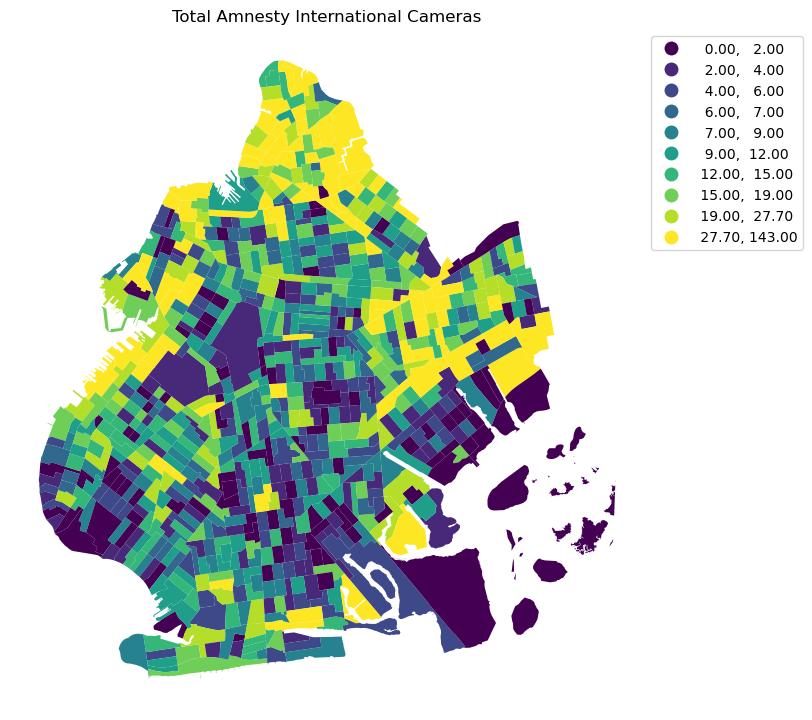

In [40]:
#plot tot amnesty int. cameras
fig,ax = plt.subplots(figsize = (8,8))
tot_agg.plot(column = 'n_cameras_median',ax = ax,
             k=10, scheme='Quantiles',legend=True,
             missing_kwds={"color": "lightgrey", ## what to do with missing values
                                         "edgecolor": "red",
                                        "hatch": "///",
                                        "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
plt.title('Total Amnesty International Cameras')
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()
fig.savefig('../Outputs/Total_Amnesty_Cameras_TractsBK.png',bbox_inches = 'tight')

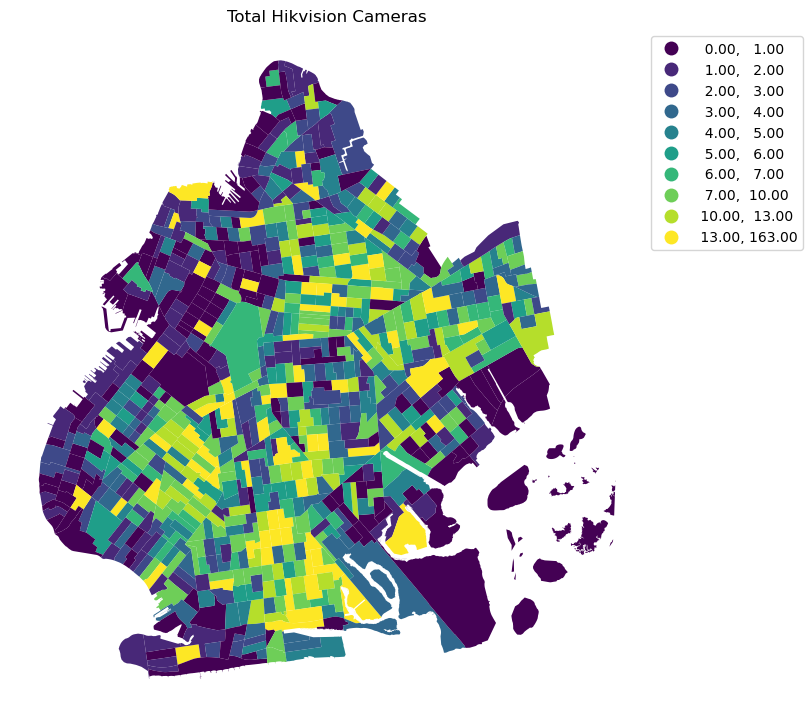

In [41]:
#plot hikvision cameras
fig,ax = plt.subplots(figsize = (8,8))
tot_agg.plot(column = 'hikvision_camera_count',ax = ax,
             k=10, scheme='Quantiles',legend=True,
             missing_kwds={"color": "lightgrey", ## what to do with missing values
                                         "edgecolor": "red",
                                        "hatch": "///",
                                        "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
plt.title('Total Hikvision Cameras')
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()
fig.savefig('../Outputs/Total_Hikvision_Cameras_TractsBK.png',bbox_inches = 'tight')

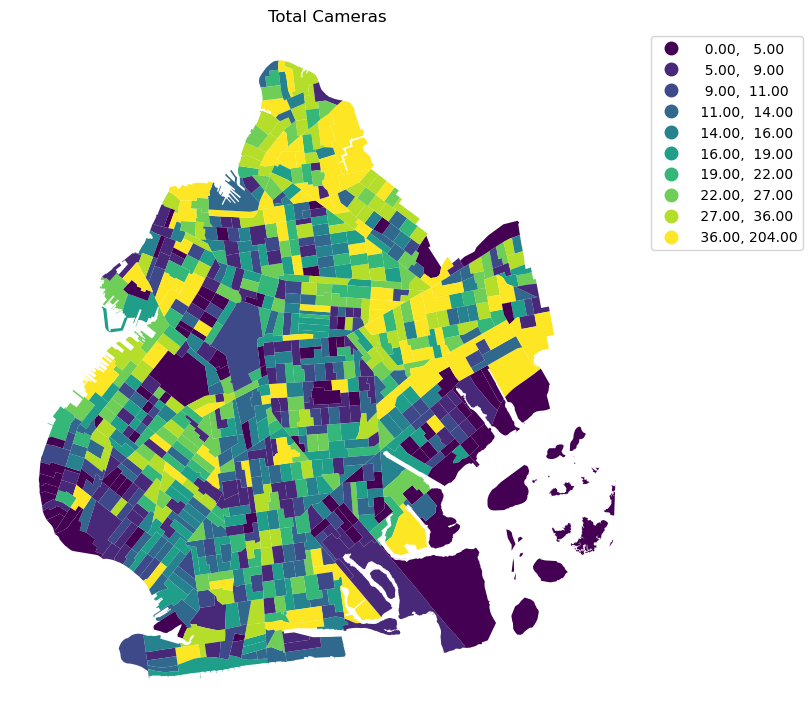

In [42]:
#plot total cameras
fig,ax = plt.subplots(figsize = (8,8))
tot_agg.plot(column = 'tot_camera_count',ax = ax,
             k=10, scheme='Quantiles',legend=True,
             missing_kwds={"color": "lightgrey", ## what to do with missing values
                                         "edgecolor": "red",
                                        "hatch": "///",
                                        "label": "Missing values",}
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
plt.title('Total Cameras')
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()
fig.savefig('../Outputs/Total_Cameras_TractsBK.png',bbox_inches = 'tight')

### Notes:

Geographical Census Unit:

* Census Tracts: Potential issues with double counting

* Census Block Groups: More representative of neighborhoods, will also encounter double counting but less than census tracts

If we use field of vision metrics as a buffer zone around camera point locations, we can allocate geographies to specific camera locations more accurately. Double counting is okay if the use case truly makes sense.


**IDEAL END TABLE COLUMNS:**

GEOID | TOTAL AMNESTY CAMERAS | TOTAL ATTACHED (Private) | TOTAL STREET (Public) | TOTAL HIKVISION (Private) | GEOMETRY

Standardization Techniques:

* Based on population: cameras per resident

* Z-score: $\frac{(x - \mu)}{\sigma}$ Note this statistical standardization technique is dependent on the distribution of the per capita metric. 